Meilleur coût total : 1666.05
Camion 1 : Chemin - Dépôt -> 53 -> 58 -> Dépôt | Poids : 32
  Distance parcourue par le camion 1 : 9.57 km
Camion 2 : Chemin - Dépôt -> 27 -> 69 -> 1 -> 70 -> Dépôt | Poids : 37
  Distance parcourue par le camion 2 : 43.44 km
Camion 3 : Chemin - Dépôt -> 28 -> 26 -> 80 -> Dépôt | Poids : 39
  Distance parcourue par le camion 3 : 91.96 km
Camion 4 : Chemin - Dépôt -> 89 -> Dépôt | Poids : 15
  Distance parcourue par le camion 4 : 122.06 km
Camion 5 : Chemin - Dépôt -> 6 -> 96 -> 93 -> Dépôt | Poids : 36
  Distance parcourue par le camion 5 : 151.48 km
Camion 6 : Chemin - Dépôt -> 13 -> 100 -> Dépôt | Poids : 40
  Distance parcourue par le camion 6 : 196.8 km
Camion 7 : Chemin - Dépôt -> 40 -> 74 -> 25 -> Dépôt | Poids : 23
  Distance parcourue par le camion 7 : 265.69 km
Camion 8 : Chemin - Dépôt -> 52 -> 18 -> 60 -> Dépôt | Poids : 24
  Distance parcourue par le camion 8 : 324.87 km
Camion 9 : Chemin - Dépôt -> 94 -> 97 -> 91 -> Dépôt | Poids : 40
  Distan

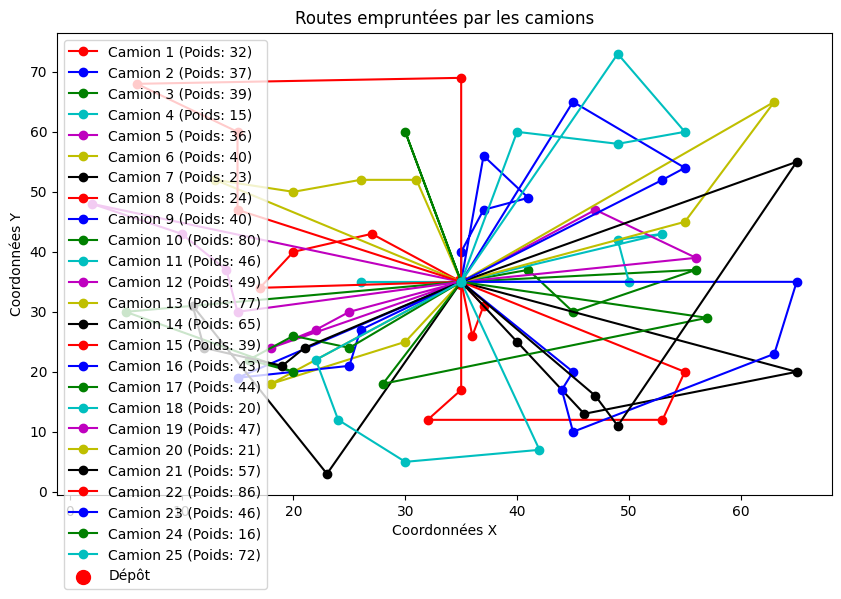

In [28]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

# Step 1: Parse Data
def parse_data(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()

        vehicle_index = next(i for i, line in enumerate(lines) if "VEHICLE" in line)
        max_vehicles = int(lines[vehicle_index + 2].split()[0])
        vehicle_capacity = int(lines[vehicle_index + 2].split()[1])

        customer_index = next(i for i, line in enumerate(lines) if "CUSTOMER" in line)
        depot_coords = None
        ready_time = None
        due_date = None
        customer_data = []

        for line in lines[customer_index + 2:]:
            data = line.strip().split()
            if len(data) == 7:
                customer_id = int(data[0])
                xcoord = float(data[1])
                ycoord = float(data[2])
                demand = int(data[3])
                ready_time_cust = int(data[4])
                due_date_cust = int(data[5])
                service_time = int(data[6])
                
                if customer_id == 0:
                    depot_coords = {'x': xcoord, 'y': ycoord}
                    ready_time = ready_time_cust
                    due_date = due_date_cust
                else:
                    customer_data.append({
                        'id': customer_id,
                        'x': xcoord,
                        'y': ycoord,
                        'demand': demand,
                        'ready_time': ready_time_cust,
                        'due_date': due_date_cust,
                        'service_time': service_time
                    })

        if depot_coords is None:
            raise ValueError("Coordonnées du dépôt manquantes ou incorrectes dans le fichier.")
        return depot_coords, ready_time, due_date, max_vehicles, vehicle_capacity, customer_data
    except Exception as e:
        print(f"An error occurred while parsing data: {e}")
        return None


# ACO Class
class AntColonyOptimization:
    def __init__(self, num_vehicles, vehicle_capacity, customer_data, depot_coords, depot_ready_time, depot_due_date):
        self.num_vehicles = num_vehicles
        self.vehicle_capacity = vehicle_capacity
        self.customer_data = customer_data
        self.depot_coords = depot_coords
        self.depot_ready_time = depot_ready_time
        self.depot_due_date = depot_due_date
        self.distance_matrix = self.calculate_distance_matrix()
        self.pheromone = np.ones_like(self.distance_matrix)
        self.alpha = 1.0
        self.beta = 2.0
        self.best_solution = None
        self.best_cost = float('inf')
        self.unserved_customers = []  # Nouvelle liste pour clients non desservis

    def calculate_distance_matrix(self):
        num_customers = len(self.customer_data)
        matrix = np.zeros((num_customers + 1, num_customers + 1))
        for i in range(num_customers + 1):
            for j in range(i + 1, num_customers + 1):
                if i == 0:
                    dist = np.sqrt((self.depot_coords['x'] - self.customer_data[j-1]['x'])**2 +
                                   (self.depot_coords['y'] - self.customer_data[j-1]['y'])**2)
                elif j == 0:
                    dist = np.sqrt((self.depot_coords['x'] - self.customer_data[i-1]['x'])**2 +
                                   (self.depot_coords['y'] - self.customer_data[i-1]['y'])**2)
                else:
                    dist = np.sqrt((self.customer_data[i-1]['x'] - self.customer_data[j-1]['x'])**2 +
                                   (self.customer_data[i-1]['y'] - self.customer_data[j-1]['y'])**2)
                matrix[i, j] = matrix[j, i] = dist
        return matrix

    def choose_next_customer(self, visited, current_customer, truck_load, current_time):
        pheromone = self.pheromone[current_customer]
        pheromone[visited] = 0
        distance = self.distance_matrix[current_customer] + 1e-6
        probability = pheromone ** self.alpha * (1.0 / distance) ** self.beta

        if np.sum(probability) == 0:
            probability = np.ones_like(probability)
        probability /= np.sum(probability)

        for next_customer in np.argsort(-probability):  # Try customers in probability order
            if next_customer not in visited and next_customer > 0:
                customer = self.customer_data[next_customer - 1]
                if (truck_load + customer['demand'] <= self.vehicle_capacity and
                        current_time + self.distance_matrix[current_customer, next_customer] <= customer['due_date']):
                    return next_customer
        return 0  # Return to depot

    def simulate_ant(self):
        routes = []
        visited = [0]
        total_distance = 0
        current_time = self.depot_ready_time
        unserved_customers = []  # Liste des clients non desservis pour cette simulation

        for _ in range(self.num_vehicles):
            route = []
            truck_load = 0
            current_customer = 0
            route_time = current_time

            while True:
                next_customer = self.choose_next_customer(visited, current_customer, truck_load, route_time)
                if next_customer == 0:
                    break

                customer = self.customer_data[next_customer - 1]
                travel_time = self.distance_matrix[current_customer, next_customer]
                arrival_time = route_time + travel_time

                if arrival_time < customer['ready_time']:
                    arrival_time = customer['ready_time']  # Wait if arriving early
                if arrival_time > customer['due_date']:
                    unserved_customers.append(customer)  # Marquer le client comme non desservi
                    visited.append(next_customer)  # Ajouter le client comme "visité" pour éviter de le revisiter
                    continue  # Passer au client suivant

                route_time = arrival_time + customer['service_time']
                truck_load += customer['demand']
                visited.append(next_customer)
                route.append(next_customer)
                total_distance += travel_time
                current_customer = next_customer

            if route:
                routes.append((route, truck_load, total_distance))
                total_distance += self.distance_matrix[current_customer, 0]  # Return to depot
                route_time += self.distance_matrix[current_customer, 0]  # Update route time

        # Enregistrer les clients non desservis pour cette simulation
        for customer in self.customer_data:
            if customer['id'] not in visited and customer not in unserved_customers:
                unserved_customers.append(customer)

        self.unserved_customers = unserved_customers  # Met à jour la liste globale
        return routes, round(total_distance, 2)

    def run(self, iterations=100):
        for _ in range(iterations):
            solution, total_cost = self.simulate_ant()
            if total_cost < self.best_cost:
                self.best_cost = total_cost
                self.best_solution = solution
        return self.best_solution, self.best_cost, self.unserved_customers


# Plotting routes
def plot_routes(depot_coords, routes, customer_data):
    plt.figure(figsize=(10, 6))
    colors = ['r', 'b', 'g', 'c', 'm', 'y', 'k']  # Predefined colors for up to 7 trucks
    for i, (route, truck_load, _) in enumerate(routes):
        color = colors[i % len(colors)]
        x = [depot_coords['x']] + [customer_data[customer-1]['x'] for customer in route] + [depot_coords['x']]
        y = [depot_coords['y']] + [customer_data[customer-1]['y'] for customer in route] + [depot_coords['y']]
        plt.plot(x, y, marker='o', label=f"Camion {i+1} (Poids: {truck_load})", color=color)
    plt.scatter(depot_coords['x'], depot_coords['y'], color='red', s=100, label="Dépôt")
    plt.xlabel("Coordonnées X")
    plt.ylabel("Coordonnées Y")
    plt.title("Routes empruntées par les camions")
    plt.legend()
    plt.show()


# Main Process
def main():
    file_path = "../dataset/r101.txt"
    data = parse_data(file_path)
    if data is None:
        return

    depot_coords, ready_time, due_date, max_vehicles, vehicle_capacity, customer_data = data
    aco = AntColonyOptimization(max_vehicles, vehicle_capacity, customer_data, depot_coords, ready_time, due_date)
    best_solution, best_cost, unserved_customers = aco.run()

    # Affichage des résultats
    print(f"Meilleur coût total : {round(best_cost, 2)}")
    total_distance = 0  # Distance totale parcourue par tous les camions
    for i, (route, truck_load, route_distance) in enumerate(best_solution):
        customer_ids = [customer_data[customer-1]['id'] for customer in route]
        print(f"Camion {i+1} : Chemin - Dépôt -> " + " -> ".join(map(str, customer_ids)) + f" -> Dépôt | Poids : {truck_load}")
        print(f"  Distance parcourue par le camion {i+1} : {round(route_distance, 2)} km")
        total_distance += route_distance

    print(f"\nDistance totale parcourue par tous les camions : {round(total_distance, 2)} km")

    # Afficher les clients non desservis
    if unserved_customers:
        print("\nClients non desservis :")
        for customer in unserved_customers:
            print(f"Client {customer['id']} | Fenêtre de temps : [{customer['ready_time']}, {customer['due_date']}] | Demande : {customer['demand']}")
    else:
        print("\nTous les clients ont été desservis.")

    plot_routes(depot_coords, best_solution, customer_data)


if __name__ == "__main__":
    main()
